### Testing Neural Network based Anomaly Detection on simulated data

#### This code generates large dataframe containing multiple timeseries, randomly adds changes in both mean and variance (anomalies), tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [5]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

import simulated_data

#### parameters to set

In [6]:
# parameters of simulated data generation
n_series = 6

# lenghts of subject and reference time periods
refh = 12
subh = 1

# probability to correctly classify sample based purely on luck
chance = refh/(subh+refh)
# how much better than luck we want to be to say we detected an anomaly. Default is 5%
cut = chance + (1-chance) * 0.05

print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

# number of training epochs 
epochs=60

chance: 0.9230769230769231 	cut: 0.926923076923077


#### generate normal data

In [7]:
# df =  simulated_data.get_simulated_data()
df =  simulated_data.get_simulated_fixed_data()
df.head()

affected: [1] 2017-08-02 01:00:00 2017-08-02 02:00:00
affected: [1] 2017-08-03 01:00:00 2017-08-03 04:00:00
affected: [1, 3, 4] 2017-08-04 01:00:00 2017-08-04 02:00:00
affected: [1] 2017-08-05 01:00:00 2017-08-05 02:00:00
affected: [1] 2017-08-06 01:00:00 2017-08-06 04:00:00
affected: [1, 3, 4] 2017-08-07 01:00:00 2017-08-07 02:00:00


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.234309,0.098391,0.546828,0.290921,0.403015,0.245851,0
2017-08-01 00:00:01,0.230034,0.134577,0.548541,0.288414,0.399936,0.238371,0
2017-08-01 00:00:02,0.225711,0.127967,0.539710,0.287345,0.393710,0.243551,0
2017-08-01 00:00:03,0.231239,0.127110,0.543637,0.283620,0.401527,0.236844,0
2017-08-01 00:00:04,0.231674,0.141980,0.546474,0.290413,0.396456,0.235442,0


#### plot timeseries

Text(0.5,0,'time')

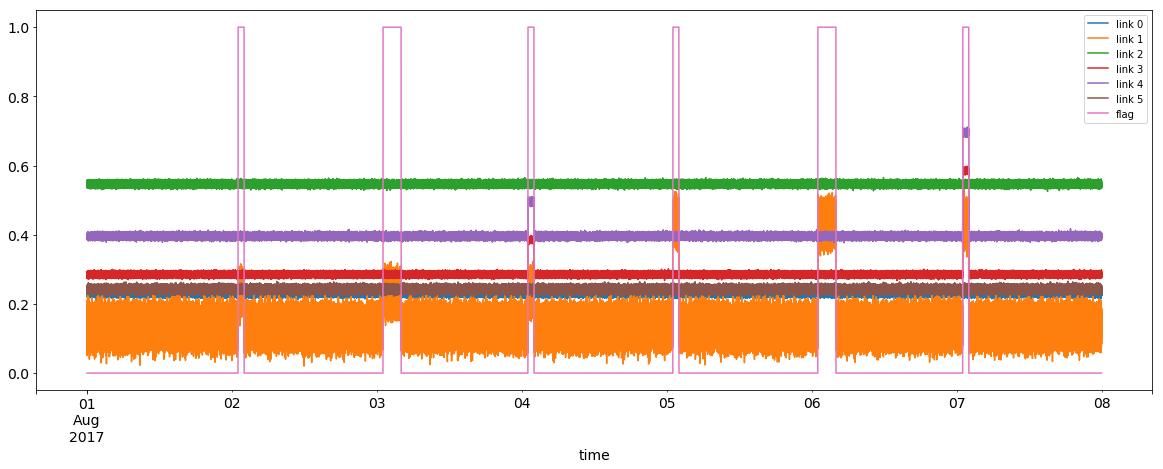

In [8]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)

#### create NN

In [9]:
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
    model.add(Dense(units=n_series*2, activation='relu'))    
#         model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid') )
    
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### This function actually checks for anomaly in one time window. It receives both referent period and subject period (one under investigation). If splits in samples in training and testing parts, shuffle them and trains model. If anomaly has been detected it plots ROC. It returns both loss and accuracy.

In [ ]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=epochs, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
        
    return loss_and_metrics[1]

#### Looping over time intervals

0
14040/14040 [==============================] - 1s 42us/step

 2017-08-01 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 26.918442010879517
1
14040/14040 [==============================] - 1s 47us/step

 2017-08-01 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.07853603363037
2
14040/14040 [==============================] - 1s 46us/step

 2017-08-01 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.284021139144897
3
14040/14040 [==============================] - 1s 45us/step

 2017-08-01 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.619789123535156
4
14040/14040 [==============================] - 1s 43us/step

 2017-08-01 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.4379243850708
5
14040/14040 [==============================] - 1s 42us/step

 2017-08-01 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.6385817527771
6
14040/14040 [==================

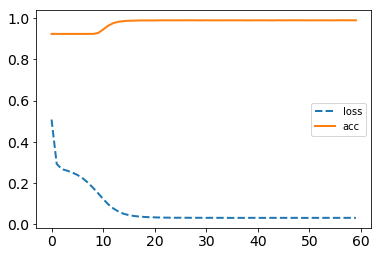


 2017-08-02 02:00:00 	refes: 43200 	subjects: 3600 	score: 0.989102564069
took: 26.171894788742065
14
14040/14040 [==============================] - 1s 56us/step

 2017-08-02 03:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 26.58221673965454
15
14040/14040 [==============================] - 1s 56us/step

 2017-08-02 04:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 26.88466787338257
16
14040/14040 [==============================] - 1s 58us/step

 2017-08-02 05:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.61575937271118
17
14040/14040 [==============================] - 1s 55us/step

 2017-08-02 06:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 26.92992925643921
18
14040/14040 [==============================] - 1s 59us/step

 2017-08-02 07:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.967838764190674
19
14040/14040 [==============================] - 1s 57us/step

 2017-08-02 08:00:00 	ref

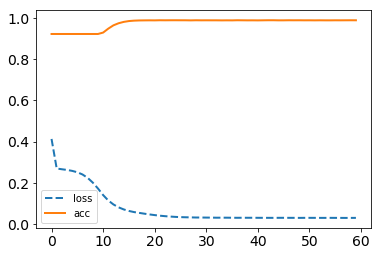


 2017-08-03 02:00:00 	refes: 43200 	subjects: 3600 	score: 0.988888888889
took: 28.10865879058838
38
14040/14040 [==============================] - 1s 73us/step

 2017-08-03 03:00:00 	refes: 43200 	subjects: 3600 	score: 0.922863247897
took: 27.763988494873047
39
14040/14040 [==============================] - 1s 83us/step

 2017-08-03 04:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 28.259670972824097
40
14040/14040 [==============================] - 1s 81us/step

 2017-08-03 05:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.846404790878296
41
14040/14040 [==============================] - 1s 79us/step

 2017-08-03 06:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 28.256529331207275
42
14040/14040 [==============================] - 1s 79us/step

 2017-08-03 07:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 28.261987924575806
43
14040/14040 [==============================] - 1s 82us/step

 2017-08-03 08:00:00 	

In [ ]:
df['score']=0.5

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
    endt=time()
    print("took:", endt-startt)
#     if count>2: break
    


#### Plots all the series, now it includes AUC values

In [ ]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)

#### Plots auc and shades periods were anomaly has been detected

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()